# 1. Dependencies

In [165]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import category_encoders as ce

# 2. Data Preprocessing and Pipeline 

In [131]:
# reading  and analyzing the data files
train_df = pd.read_excel("../data/Train_dataset.xlsx", sheet_name="Train_dataset")
test_df = pd.read_excel("../data/Test_dataset.xlsx", sheet_name="Test_dataset")

## 2.1 Cleaning the data (Removing the redundant/irrelevant variable)

In [132]:
## People_Id, Name does not determine(or might be but its rarest) Infect_prod, 
## Designation and Gender are same 

In [133]:
train_df = train_df.drop(columns=['Name', 'Designation', 'people_ID'], axis=1);
test_df = test_df.drop(columns=['Name', 'Designation'], axis=1)

In [134]:
train_df.head(5)

,Region,Gender,Married,Children,Occupation,Mode_transport,cases/1M,Deaths/1M,comorbidity,Age,...,HBB,d-dimer,Heart rate,HDL cholesterol,Charlson Index,Blood Glucose,Insurance,salary,FT/month,Infect_Prob
0,Bhubaneshwar,Female,YES,1.0,Farmer,Public,2,0,Hypertension,68,...,93.0,233.0,82.0,58.0,27,7,3600000.0,1300000,2.0,49.135010
1,Bhubaneshwar,Female,YES,2.0,Farmer,Walk,2,0,Diabetes,64,...,56.0,328.0,89.0,68.0,5,6,1600000.0,400000,1.0,51.147880
2,Bhubaneshwar,Female,NO,1.0,Cleaner,Public,2,0,None,19,...,137.0,213.0,77.0,43.0,40,6,3400000.0,900000,1.0,73.224000
3,Bhubaneshwar,Female,YES,1.0,Driver,Car,2,0,Coronary Heart Disease,33,...,167.0,275.0,64.0,60.0,27,7,700000.0,2300000,1.0,48.779225
4,Bhubaneshwar,Female,NO,2.0,Manufacturing,Car,2,0,Diabetes,23,...,153.0,331.0,71.0,64.0,32,7,3200000.0,1100000,1.0,87.868800


## 2.2 EDA (Data Visualization)

### 2.2.1 Missing data visualisation, White fields indicate NaNs

In [136]:
train_copy = train_df.replace("nan", np.nan)

In [137]:
test_copy = test_df.replace("nan", np.nan)

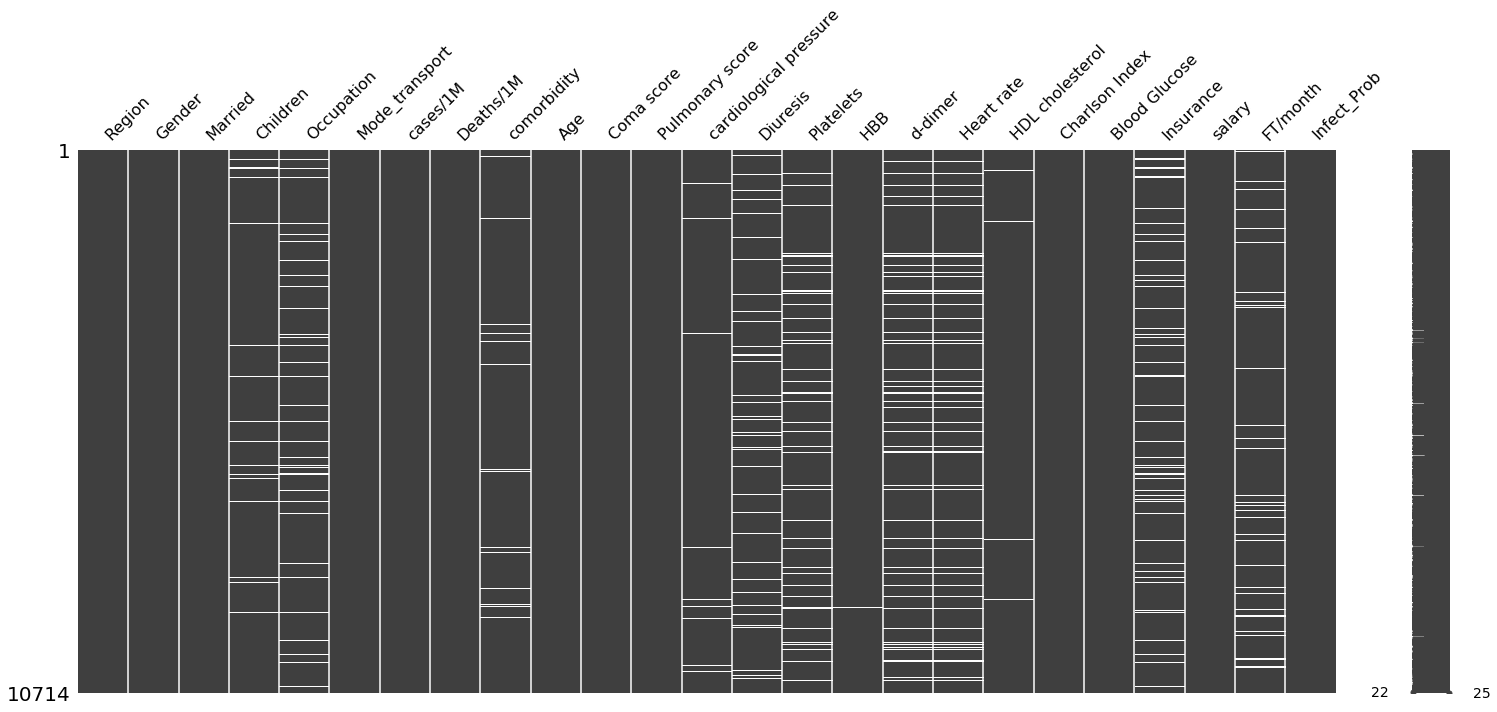

In [138]:
# missing values in training data
msno.matrix(train_copy);

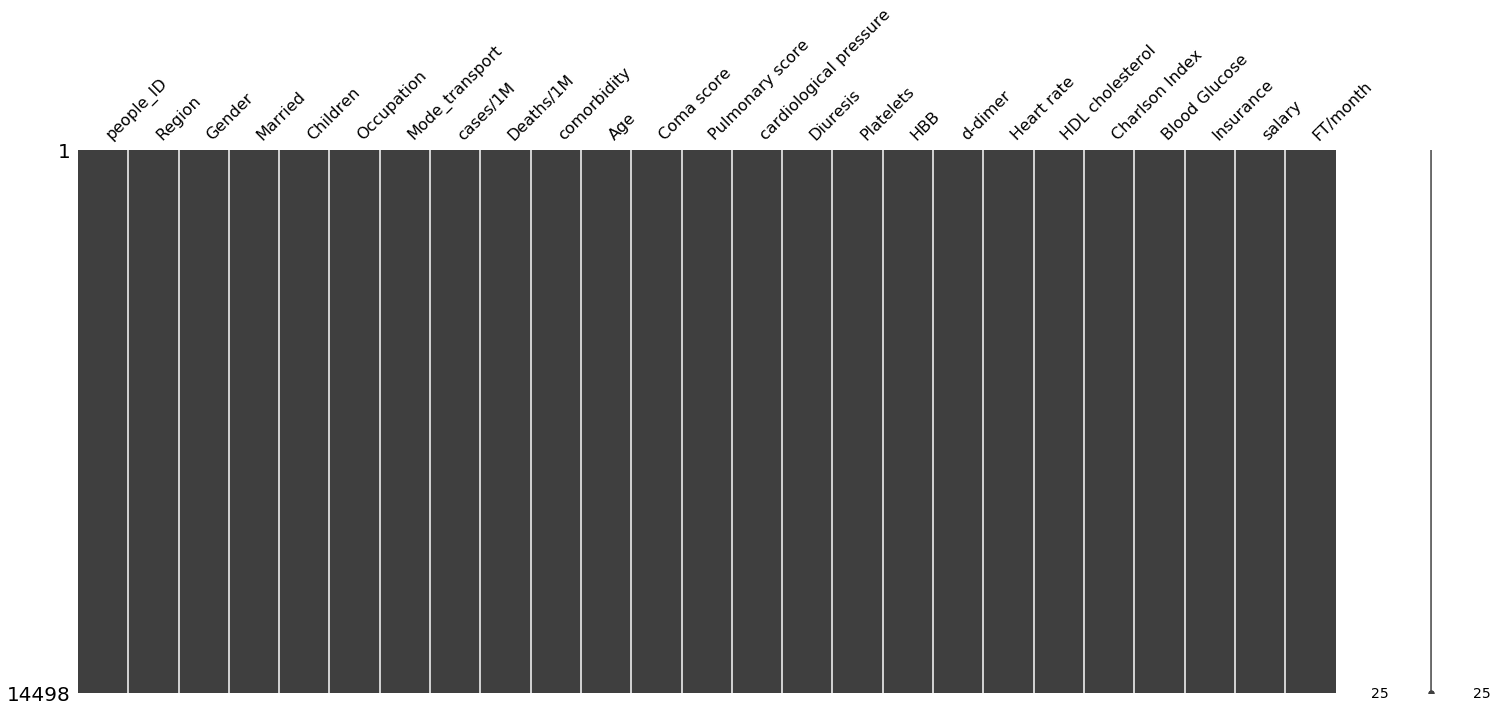

In [139]:
# missing values in test data (Its unlikely that there will be  any missing values in test data but lets c)
msno.matrix(test_df);

### 2.2.2 Correlation heatmap

In [140]:
# missingno heatmap measures nullity correlation, how the presence or absence or a variable
# Nullity correlation ranges from -1 (if one variable appears the other definitely does not) to 0 
# (variables appearing or not appearing have no effect on one another) to 1 (if one variable appears 
# the other definitely also does).

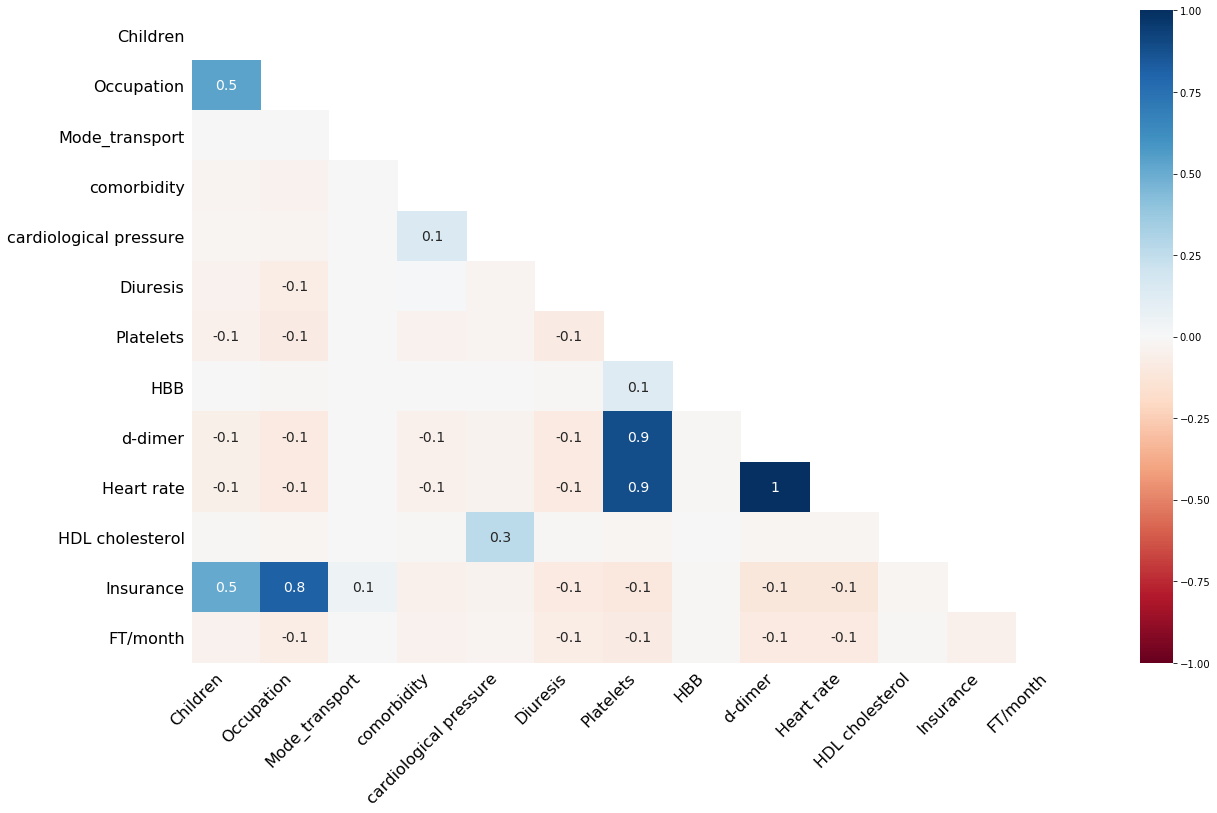

In [141]:
msno.heatmap(train_copy);

### 2.2.3 Dendrogram

In [142]:
### The dendrogram allows us to more fully correlate variable completion, 
### revealing trends deeper than the pairwise ones visible in the correlation heatmap:

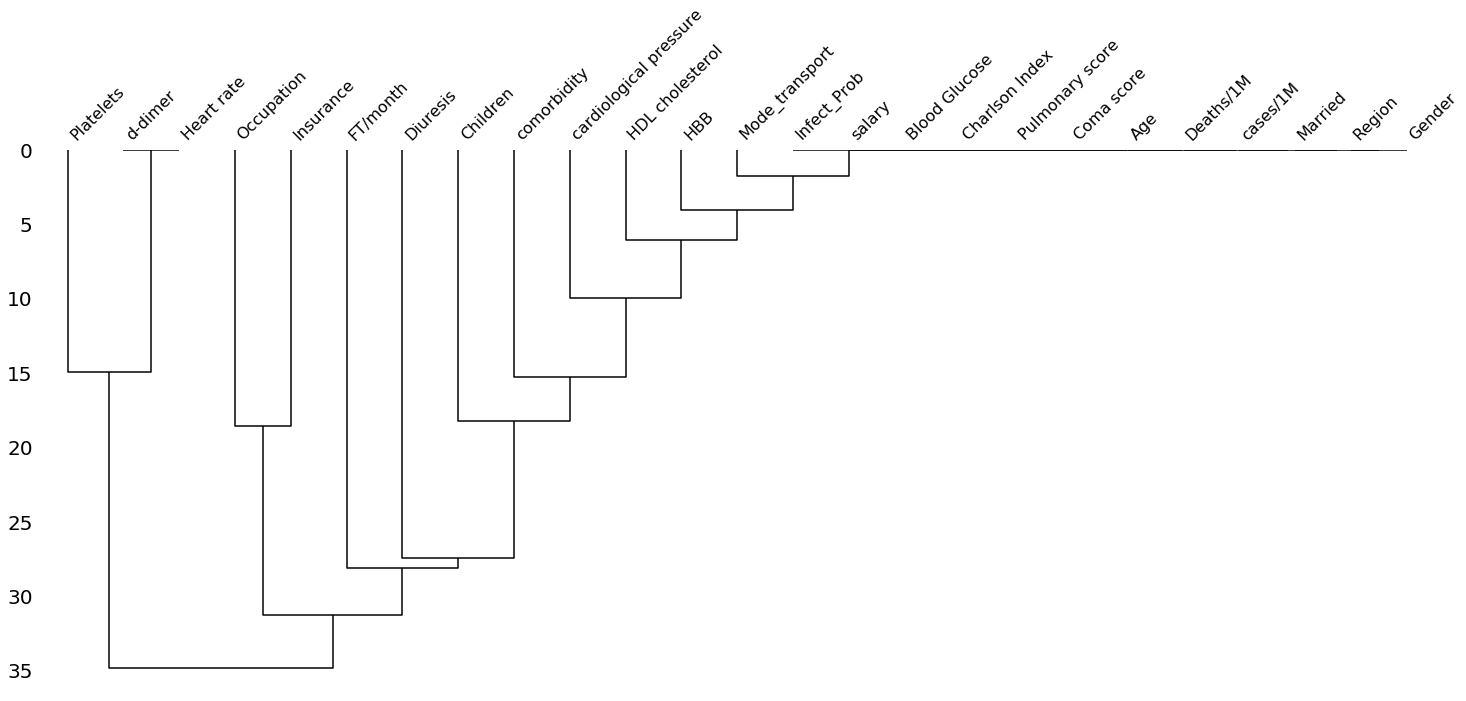

In [143]:
msno.dendrogram(train_copy);

## 2.3 Handling the Missing values
- We going to deal with the numerical missing data and categorical missing data differently

In [144]:
# how many missing values each col has
for col in train_df.columns:
    print(train_df[col].isnull().values.sum())

0
0
0
311
747
3
0
0
226
0
0
0
97
716
924
16
1114
1114
35
0
0
1090
0
723
0


In [145]:
num_train = train_df.select_dtypes(include='number');
cat_train = train_df.select_dtypes(exclude='number');

In [146]:
print(f'{train_df.shape[1] == num_train.shape[1] + cat_train.shape[1]}')

True


### 2.3.1 Numerical NaNs

In [147]:
from sklearn.impute import SimpleImputer

In [148]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

In [149]:
for col in num_train:
    train_df[[col]] = imputer.fit_transform(train_df[[col]])

### 2.3.2 Categorical NaNs

In [150]:
imputer = SimpleImputer(strategy='most_frequent')

In [152]:
for col in cat_train:
    train_df[[col]] = imputer.fit_transform(train_df[[col]])  

In [154]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10714 entries, 0 to 10713
Data columns (total 25 columns):
Region                    10714 non-null object
Gender                    10714 non-null object
Married                   10714 non-null object
Children                  10714 non-null float64
Occupation                10714 non-null object
Mode_transport            10714 non-null object
cases/1M                  10714 non-null float64
Deaths/1M                 10714 non-null float64
comorbidity               10714 non-null object
Age                       10714 non-null float64
Coma score                10714 non-null float64
Pulmonary score           10714 non-null object
cardiological pressure    10714 non-null object
Diuresis                  10714 non-null float64
Platelets                 10714 non-null float64
HBB                       10714 non-null float64
d-dimer                   10714 non-null float64
Heart rate                10714 non-null float64
HDL cholesterol  

## 2.4 Pair Visualization

In [ ]:
x_vars = train_df.columns[:-1]
y_vars = train_df.columns[-1]

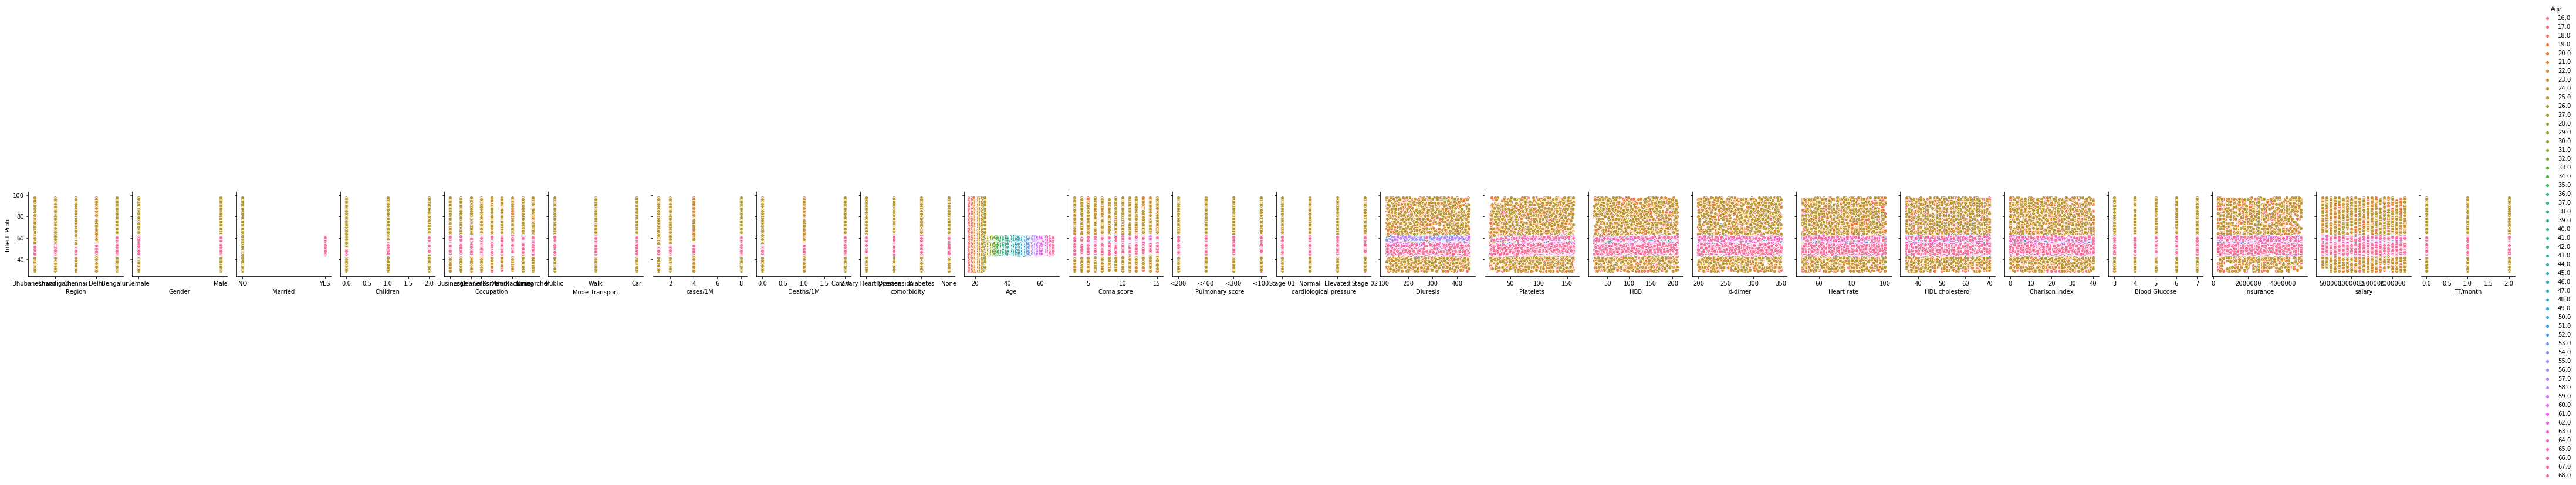

In [164]:
sns.pairplot(train_df, x_vars=x_vars, y_vars=y_vars, diag_kind="kde", hue='Age');

In [159]:
# from the above plot we can drive many conclusion such that Infect_Prob is 
# lower among Married folks similarly we can drive many conclusion

## 2.5 Dealing with Categorical Data